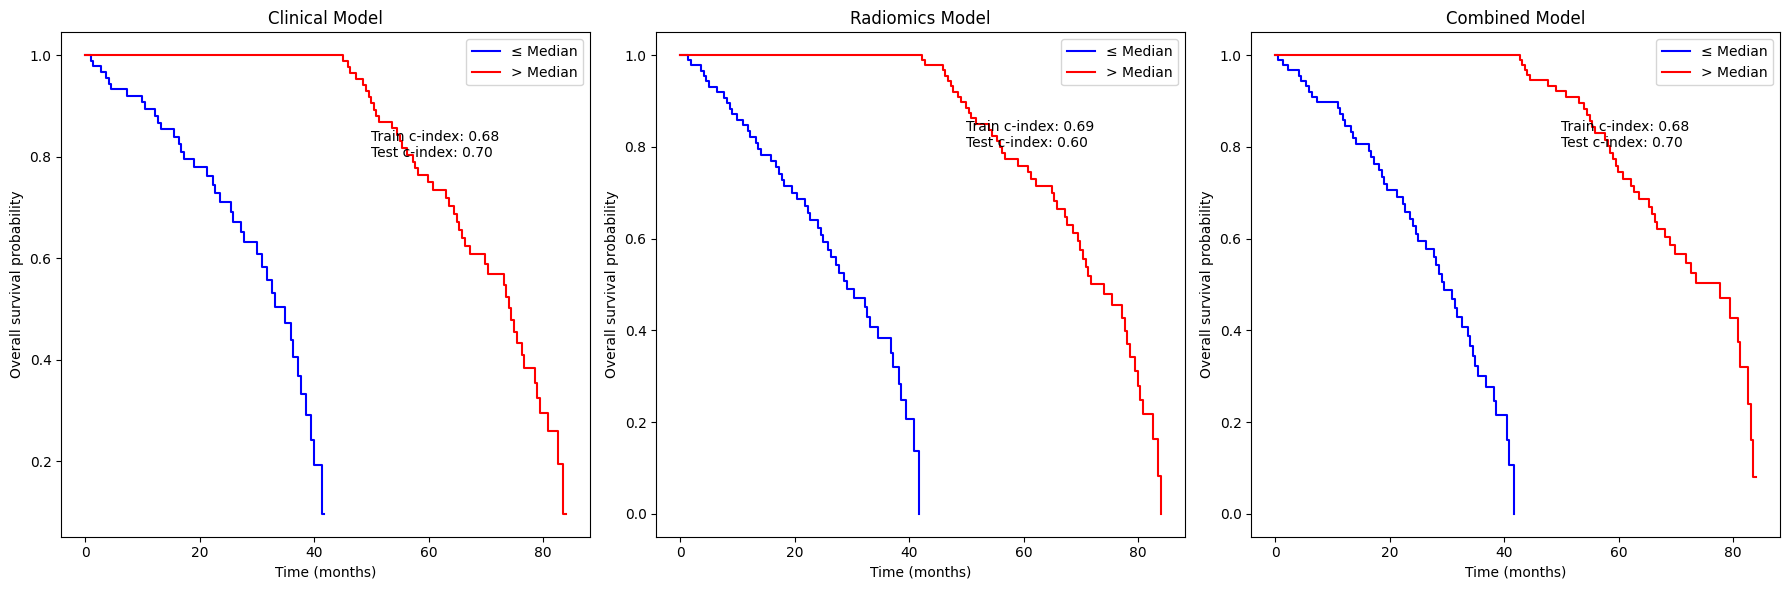

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import KaplanMeierFitter

# Dummy data (replace with actual data)
time_clinical = np.linspace(0, 84, 186)
event_clinical = np.random.randint(0, 2, 186)
time_radiomics = np.linspace(0, 84, 186)
event_radiomics = np.random.randint(0, 2, 186)
time_combined = np.linspace(0, 84, 186)
event_combined = np.random.randint(0, 2, 186)

# Define c-index values (replace with actual values)
c_index_clinical_train = 0.68
c_index_clinical_test = 0.70
c_index_radiomics_train = 0.69
c_index_radiomics_test = 0.60
c_index_combined_train = 0.68
c_index_combined_test = 0.70

# Median split for <= Median and > Median groups
median_time = np.median(time_clinical)

# Create Kaplan-Meier fitter instances
kmf_clinical = KaplanMeierFitter()
kmf_radiomics = KaplanMeierFitter()
kmf_combined = KaplanMeierFitter()

# Fit the models
kmf_clinical.fit(time_clinical[time_clinical <= median_time], event_clinical[time_clinical <= median_time], label='≤ Median')
kmf_clinical_greater = KaplanMeierFitter().fit(time_clinical[time_clinical > median_time], event_clinical[time_clinical > median_time], label='> Median')
kmf_radiomics.fit(time_radiomics[time_radiomics <= median_time], event_radiomics[time_radiomics <= median_time], label='≤ Median')
kmf_radiomics_greater = KaplanMeierFitter().fit(time_radiomics[time_radiomics > median_time], event_radiomics[time_radiomics > median_time], label='> Median')
kmf_combined.fit(time_combined[time_combined <= median_time], event_combined[time_combined <= median_time], label='≤ Median')
kmf_combined_greater = KaplanMeierFitter().fit(time_combined[time_combined > median_time], event_combined[time_combined > median_time], label='> Median')

# Plot the survival functions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Clinical Model Plot
kmf_clinical.plot(ax=axes[0], ci_show=False, color='blue')
kmf_clinical_greater.plot(ax=axes[0], ci_show=False, color='red')
axes[0].set_title('Clinical Model')
axes[0].set_xlabel('Time (months)')
axes[0].set_ylabel('Overall survival probability')
axes[0].legend(['≤ Median', '> Median'])
axes[0].text(50, 0.8, f'Train c-index: {c_index_clinical_train:.2f}\nTest c-index: {c_index_clinical_test:.2f}', fontsize=10)

# Radiomics Model Plot
kmf_radiomics.plot(ax=axes[1], ci_show=False, color='blue')
kmf_radiomics_greater.plot(ax=axes[1], ci_show=False, color='red')
axes[1].set_title('Radiomics Model')
axes[1].set_xlabel('Time (months)')
axes[1].set_ylabel('Overall survival probability')
axes[1].legend(['≤ Median', '> Median'])
axes[1].text(50, 0.8, f'Train c-index: {c_index_radiomics_train:.2f}\nTest c-index: {c_index_radiomics_test:.2f}', fontsize=10)

# Combined Model Plot
kmf_combined.plot(ax=axes[2], ci_show=False, color='blue')
kmf_combined_greater.plot(ax=axes[2], ci_show=False, color='red')
axes[2].set_title('Combined Model')
axes[2].set_xlabel('Time (months)')
axes[2].set_ylabel('Overall survival probability')
axes[2].legend(['≤ Median', '> Median'])
axes[2].text(50, 0.8, f'Train c-index: {c_index_combined_train:.2f}\nTest c-index: {c_index_combined_test:.2f}', fontsize=10)

plt.tight_layout()
plt.show()


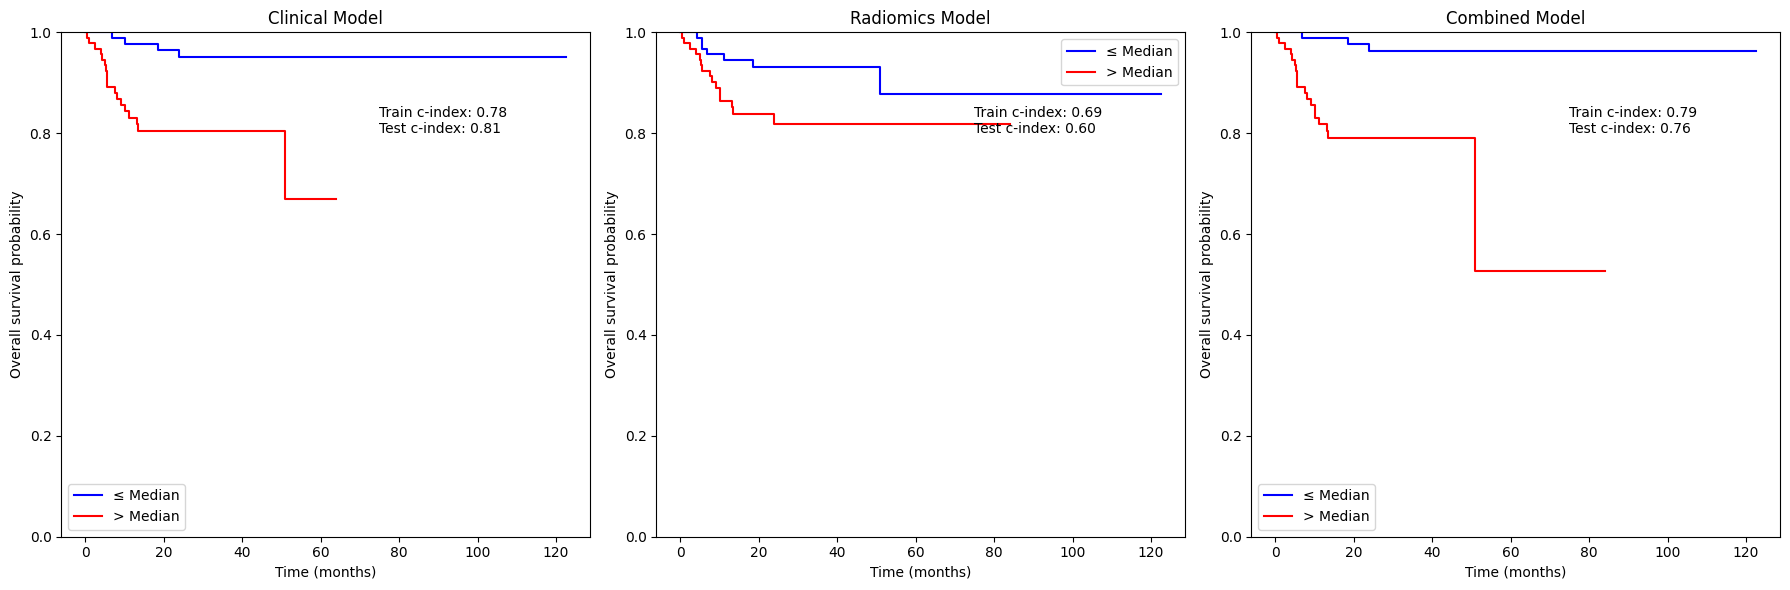

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

# Load data
df = pd.read_csv('/Intern Programming/data/OPCdigits_t1t2_split.csv')
radiodata = pd.read_csv('/Intern Programming/data/output/umcg_radiomicsfeature_t1_GTVPT.csv', index_col='Unnamed: 0')

# Merge the two dataframes based on the patient ID column
merged_data = pd.merge(df, radiodata, on='PatientID')

# Split data into training and test sets
df_train = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'train']
df_test = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'test']

# Define variables
time_vars = ['TIME_LR', 'TIME_RR', 'TIME_LRR', 'TIME_MET', 'TIME_TumorSpecificSurvival', 'TIME_OS', 'TIME_DFS', 'TIME_RFS']
event_vars = ['LR_code', 'RR_code', 'LRR_code', 'MET_code', 'TumorSpecificSurvival_code', 'OS_code', 'DFS_code', 'RFS_code']

# Define significant predictors
sig_predictors = ['AGE', 'GESLACHT_codes', 'PACK_YEARS', 'TSTAD_codes_123VS4', 'NSTAD_codes_N01VSN2VSN3', 'P16_codes_newexperi', 'WHO_SCORE_codes_0VS123']
radio_predictors = ['original_glszm_ZoneEntropy', 'original_firstorder_Range']  # Replace with actual radiomics predictors for each outcome

# Define outcome index (e.g., 0 for TIME_LR and LR_code)
outcome_idx = 0

# Combine predictors for the combined model
combined_predictors = sig_predictors + radio_predictors

# Initialize Cox Proportional Hazards model for clinical, radiomics, and combined models
cph_clinical = CoxPHFitter()
cph_radiomics = CoxPHFitter()
cph_combined = CoxPHFitter()

# Fit the models on training data
cph_clinical.fit(df_train[sig_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_radiomics.fit(df_train[radio_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_combined.fit(df_train[combined_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])

# Predict partial hazards for training data
train_pred_clinical = cph_clinical.predict_partial_hazard(df_train[sig_predictors])
train_pred_radiomics = cph_radiomics.predict_partial_hazard(df_train[radio_predictors])
train_pred_combined = cph_combined.predict_partial_hazard(df_train[combined_predictors])

# Calculate concordance index for training data
train_cindex_clinical = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_clinical, df_train[event_vars[outcome_idx]])
train_cindex_radiomics = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_radiomics, df_train[event_vars[outcome_idx]])
train_cindex_combined = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_combined, df_train[event_vars[outcome_idx]])

# Predict partial hazards for test data
test_pred_clinical = cph_clinical.predict_partial_hazard(df_test[sig_predictors])
test_pred_radiomics = cph_radiomics.predict_partial_hazard(df_test[radio_predictors])
test_pred_combined = cph_combined.predict_partial_hazard(df_test[combined_predictors])

# Calculate concordance index for test data
test_cindex_clinical = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_clinical, df_test[event_vars[outcome_idx]])
test_cindex_radiomics = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_radiomics, df_test[event_vars[outcome_idx]])
test_cindex_combined = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_combined, df_test[event_vars[outcome_idx]])

# Plot Kaplan-Meier survival curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot KM curves
def plot_km_curves(kmf, df, preds, time_var, event_var, title, ax, cindex_train, cindex_test):
    median_pred = preds.median()
    kmf.fit(df[time_var][preds <= median_pred], event_observed=df[event_var][preds <= median_pred], label='≤ Median')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='blue')
    kmf.fit(df[time_var][preds > median_pred], event_observed=df[event_var][preds > median_pred], label='> Median')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='red')
    ax.set_title(title)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Overall survival probability')
    ax.legend()
    ax.set_ylim(0, 1)  # Set y-axis limits to 0-1 for survival probability
    ax.text(0.6, 0.8, f'Train c-index: {cindex_train:.2f}\nTest c-index: {cindex_test:.2f}', transform=ax.transAxes)

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot clinical model KM curves
plot_km_curves(kmf, df_train, train_pred_clinical, time_vars[outcome_idx], event_vars[outcome_idx], 'Clinical Model', axes[0], train_cindex_clinical, test_cindex_clinical)

# Plot radiomics model KM curves
plot_km_curves(kmf, df_train, train_pred_radiomics, time_vars[outcome_idx], event_vars[outcome_idx], 'Radiomics Model', axes[1], train_cindex_radiomics, test_cindex_radiomics)

# Plot combined model KM curves
plot_km_curves(kmf, df_train, train_pred_combined, time_vars[outcome_idx], event_vars[outcome_idx], 'Combined Model', axes[2], train_cindex_combined, test_cindex_combined)

plt.tight_layout()
plt.show()


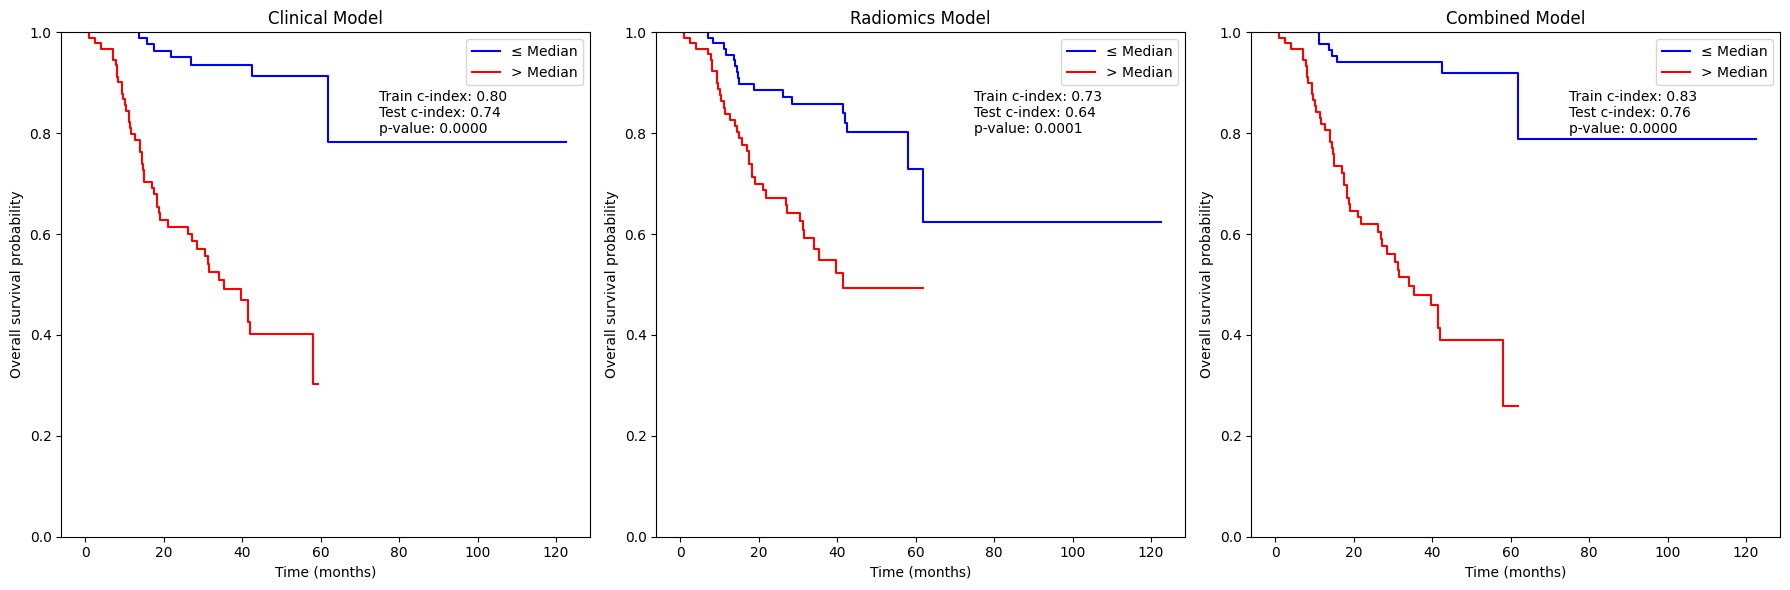

In [13]:
## with p value 


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

# Load data
df = pd.read_csv('/Intern Programming/data/OPCdigits_t1t2_split.csv')
radiodata = pd.read_csv('/Intern Programming/data/output/umcg_radiomicsfeature_t1_GTVPT.csv', index_col='Unnamed: 0')

# Merge the two dataframes based on the patient ID column
merged_data = pd.merge(df, radiodata, on='PatientID')

# Split data into training and test sets
df_train = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'train']
df_test = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'test']

# Define variables
time_vars = ['TIME_LR', 'TIME_RR', 'TIME_LRR', 'TIME_MET', 'TIME_TumorSpecificSurvival', 'TIME_OS', 'TIME_DFS', 'TIME_RFS']
event_vars = ['LR_code', 'RR_code', 'LRR_code', 'MET_code', 'TumorSpecificSurvival_code', 'OS_code', 'DFS_code', 'RFS_code']

# Define significant predictors
sig_predictors = ['AGE', 'GESLACHT_codes', 'PACK_YEARS', 'TSTAD_codes_123VS4', 'NSTAD_codes_N01VSN2VSN3', 'P16_codes_newexperi', 'WHO_SCORE_codes_0VS123']
radio_predictors = ['original_glszm_ZoneEntropy', 'original_firstorder_Minimum']  # Replace with actual radiomics predictors for each outcome

# Define outcome index (e.g., 0 for TIME_LR and LR_code)
outcome_idx = 5

# Combine predictors for the combined model
combined_predictors = sig_predictors + radio_predictors

# Initialize Cox Proportional Hazards model for clinical, radiomics, and combined models
cph_clinical = CoxPHFitter()
cph_radiomics = CoxPHFitter()
cph_combined = CoxPHFitter()

# Fit the models on training data
cph_clinical.fit(df_train[sig_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_radiomics.fit(df_train[radio_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_combined.fit(df_train[combined_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])

# Predict partial hazards for training data
train_pred_clinical = cph_clinical.predict_partial_hazard(df_train[sig_predictors])
train_pred_radiomics = cph_radiomics.predict_partial_hazard(df_train[radio_predictors])
train_pred_combined = cph_combined.predict_partial_hazard(df_train[combined_predictors])

# Calculate concordance index for training data
train_cindex_clinical = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_clinical, df_train[event_vars[outcome_idx]])
train_cindex_radiomics = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_radiomics, df_train[event_vars[outcome_idx]])
train_cindex_combined = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_combined, df_train[event_vars[outcome_idx]])

# Predict partial hazards for test data
test_pred_clinical = cph_clinical.predict_partial_hazard(df_test[sig_predictors])
test_pred_radiomics = cph_radiomics.predict_partial_hazard(df_test[radio_predictors])
test_pred_combined = cph_combined.predict_partial_hazard(df_test[combined_predictors])

# Calculate concordance index for test data
test_cindex_clinical = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_clinical, df_test[event_vars[outcome_idx]])
test_cindex_radiomics = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_radiomics, df_test[event_vars[outcome_idx]])
test_cindex_combined = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_combined, df_test[event_vars[outcome_idx]])

# Plot Kaplan-Meier survival curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot KM curves
def plot_km_curves(kmf, df, preds, time_var, event_var, title, ax, cindex_train, cindex_test):
    median_pred = preds.median()
    kmf.fit(df[time_var][preds <= median_pred], event_observed=df[event_var][preds <= median_pred], label='≤ Median')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='blue')
    kmf.fit(df[time_var][preds > median_pred], event_observed=df[event_var][preds > median_pred], label='> Median')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='red')
    
    # Calculate p-value using log-rank test
    results = logrank_test(df[time_var][preds <= median_pred], df[time_var][preds > median_pred], 
                           event_observed_A=df[event_var][preds <= median_pred], 
                           event_observed_B=df[event_var][preds > median_pred])
    p_value = results.p_value
    
    ax.set_title(title)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Overall survival probability')
    ax.legend()
    ax.set_ylim(0, 1)  # Set y-axis limits to 0-1 for survival probability
    ax.text(0.6, 0.8, f'Train c-index: {cindex_train:.2f}\nTest c-index: {cindex_test:.2f}\np-value: {p_value:.2e}', transform=ax.transAxes)

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot clinical model KM curves
plot_km_curves(kmf, df_train, train_pred_clinical, time_vars[outcome_idx], event_vars[outcome_idx], 'Clinical Model', axes[0], train_cindex_clinical, test_cindex_clinical)

# Plot radiomics model KM curves
plot_km_curves(kmf, df_train, train_pred_radiomics, time_vars[outcome_idx], event_vars[outcome_idx], 'Radiomics Model', axes[1], train_cindex_radiomics, test_cindex_radiomics)

# Plot combined model KM curves
plot_km_curves(kmf, df_train, train_pred_combined, time_vars[outcome_idx], event_vars[outcome_idx], 'Combined Model', axes[2], train_cindex_combined, test_cindex_combined)

plt.tight_layout()
plt.show()


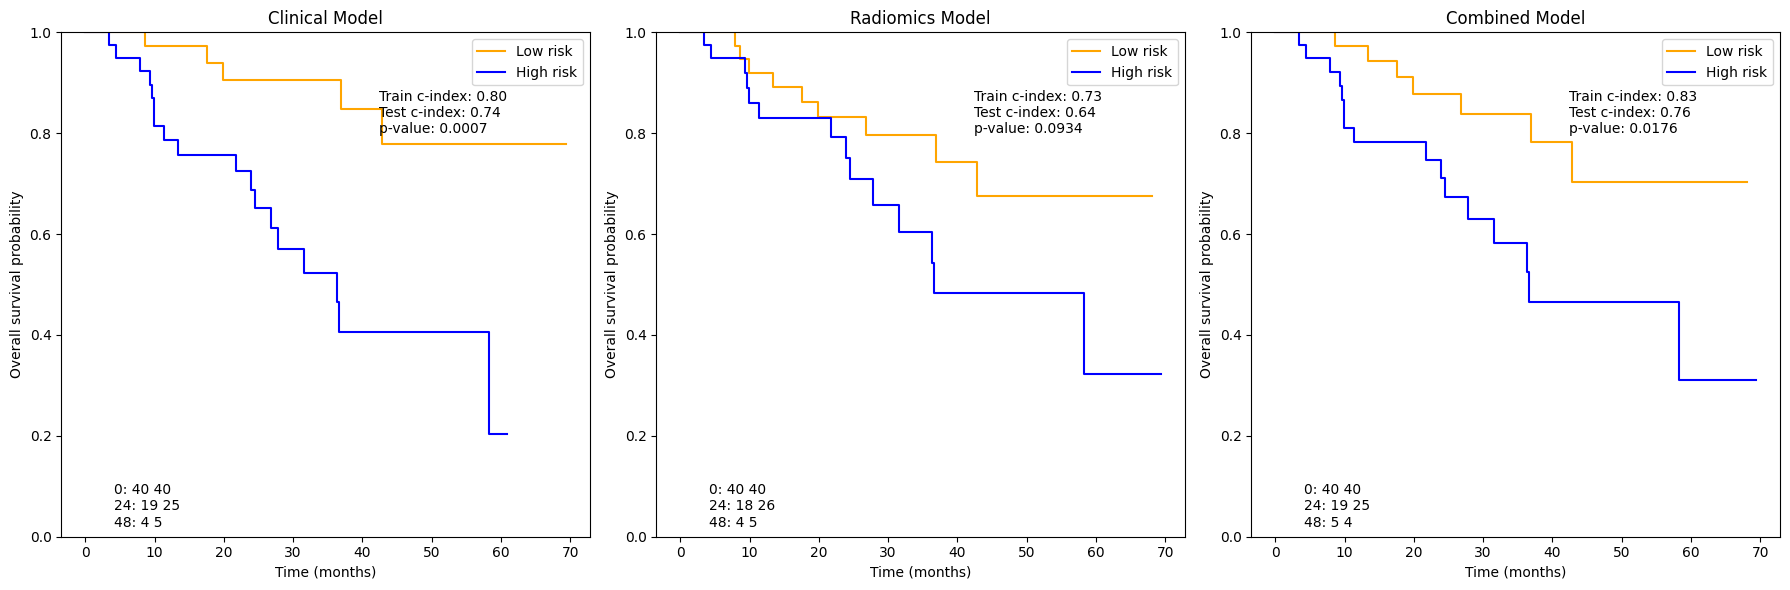

In [10]:
## HIgh low risk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

# Load data
df = pd.read_csv('/Intern Programming/data/OPCdigits_t1t2_split.csv')
radiodata = pd.read_csv('/Intern Programming/data/output/umcg_radiomicsfeature_t1_GTVPT.csv', index_col='Unnamed: 0')

# Merge the two dataframes based on the patient ID column
merged_data = pd.merge(df, radiodata, on='PatientID')

# Split data into training and test sets
df_train = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'train']
df_test = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'test']

# Define variables
time_vars = ['TIME_LR', 'TIME_RR', 'TIME_LRR', 'TIME_MET', 'TIME_TumorSpecificSurvival', 'TIME_OS', 'TIME_DFS', 'TIME_RFS']
event_vars = ['LR_code', 'RR_code', 'LRR_code', 'MET_code', 'TumorSpecificSurvival_code', 'OS_code', 'DFS_code', 'RFS_code']

# Define significant predictors
sig_predictors = ['AGE', 'GESLACHT_codes', 'PACK_YEARS', 'TSTAD_codes_123VS4', 'NSTAD_codes_N01VSN2VSN3', 'P16_codes_newexperi', 'WHO_SCORE_codes_0VS123']
radio_predictors = ['original_glszm_ZoneEntropy', 'original_firstorder_Minimum']  # Replace with actual radiomics predictors for each outcome

# Define outcome index (e.g., 0 for TIME_LR and LR_code)
outcome_idx = 5

# Combine predictors for the combined model
combined_predictors = sig_predictors + radio_predictors

# Initialize Cox Proportional Hazards model for clinical, radiomics, and combined models
cph_clinical = CoxPHFitter()
cph_radiomics = CoxPHFitter()
cph_combined = CoxPHFitter()

# Fit the models on training data
cph_clinical.fit(df_train[sig_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_radiomics.fit(df_train[radio_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_combined.fit(df_train[combined_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])

# Predict partial hazards for training data
train_pred_clinical = cph_clinical.predict_partial_hazard(df_train[sig_predictors])
train_pred_radiomics = cph_radiomics.predict_partial_hazard(df_train[radio_predictors])
train_pred_combined = cph_combined.predict_partial_hazard(df_train[combined_predictors])

# Calculate concordance index for training data
train_cindex_clinical = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_clinical, df_train[event_vars[outcome_idx]])
train_cindex_radiomics = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_radiomics, df_train[event_vars[outcome_idx]])
train_cindex_combined = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_combined, df_train[event_vars[outcome_idx]])

# Predict partial hazards for test data
test_pred_clinical = cph_clinical.predict_partial_hazard(df_test[sig_predictors])
test_pred_radiomics = cph_radiomics.predict_partial_hazard(df_test[radio_predictors])
test_pred_combined = cph_combined.predict_partial_hazard(df_test[combined_predictors])

# Calculate concordance index for test data
test_cindex_clinical = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_clinical, df_test[event_vars[outcome_idx]])
test_cindex_radiomics = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_radiomics, df_test[event_vars[outcome_idx]])
test_cindex_combined = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_combined, df_test[event_vars[outcome_idx]])

# Plot Kaplan-Meier survival curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot KM curves
def plot_km_curves(kmf, df, preds, time_var, event_var, title, ax, cindex_train, cindex_test):
    median_pred = preds.median()
    high_risk = preds > median_pred
    low_risk = preds <= median_pred
    
    kmf.fit(df[time_var][low_risk], event_observed=df[event_var][low_risk], label='Low risk')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='orange')
    kmf.fit(df[time_var][high_risk], event_observed=df[event_var][high_risk], label='High risk')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='blue')
    
    # Calculate p-value using log-rank test
    results = logrank_test(df[time_var][low_risk], df[time_var][high_risk], 
                           event_observed_A=df[event_var][low_risk], 
                           event_observed_B=df[event_var][high_risk])
    p_value = results.p_value
    
    ax.set_title(title)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Overall survival probability')
    ax.legend()
    ax.set_ylim(0, 1)  # Set y-axis limits to 0-1 for survival probability
    ax.text(0.6, 0.8, f'Train c-index: {cindex_train:.2f}\nTest c-index: {cindex_test:.2f}\np-value: {p_value:.4f}', transform=ax.transAxes)
    
    # Add number at risk
    time_points = np.arange(0, df[time_var].max(), step=24)
    at_risk_counts = [(df[time_var][high_risk] >= t).sum() for t in time_points]
    at_risk_counts_low = [(df[time_var][low_risk] >= t).sum() for t in time_points]
    at_risk_text = "\n".join([f"{t:.0f}: {ar} {al}" for t, ar, al in zip(time_points, at_risk_counts, at_risk_counts_low)])
    ax.text(0.1, 0.02, at_risk_text, transform=ax.transAxes)

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot clinical model KM curves
plot_km_curves(kmf, df_test, test_pred_clinical, time_vars[outcome_idx], event_vars[outcome_idx], 'Clinical Model', axes[0], train_cindex_clinical, test_cindex_clinical)

# Plot radiomics model KM curves
plot_km_curves(kmf, df_test, test_pred_radiomics, time_vars[outcome_idx], event_vars[outcome_idx], 'Radiomics Model', axes[1], train_cindex_radiomics, test_cindex_radiomics)

# Plot combined model KM curves
plot_km_curves(kmf, df_test, test_pred_combined, time_vars[outcome_idx], event_vars[outcome_idx], 'Combined Model', axes[2], train_cindex_combined, test_cindex_combined)

plt.tight_layout()
plt.show()


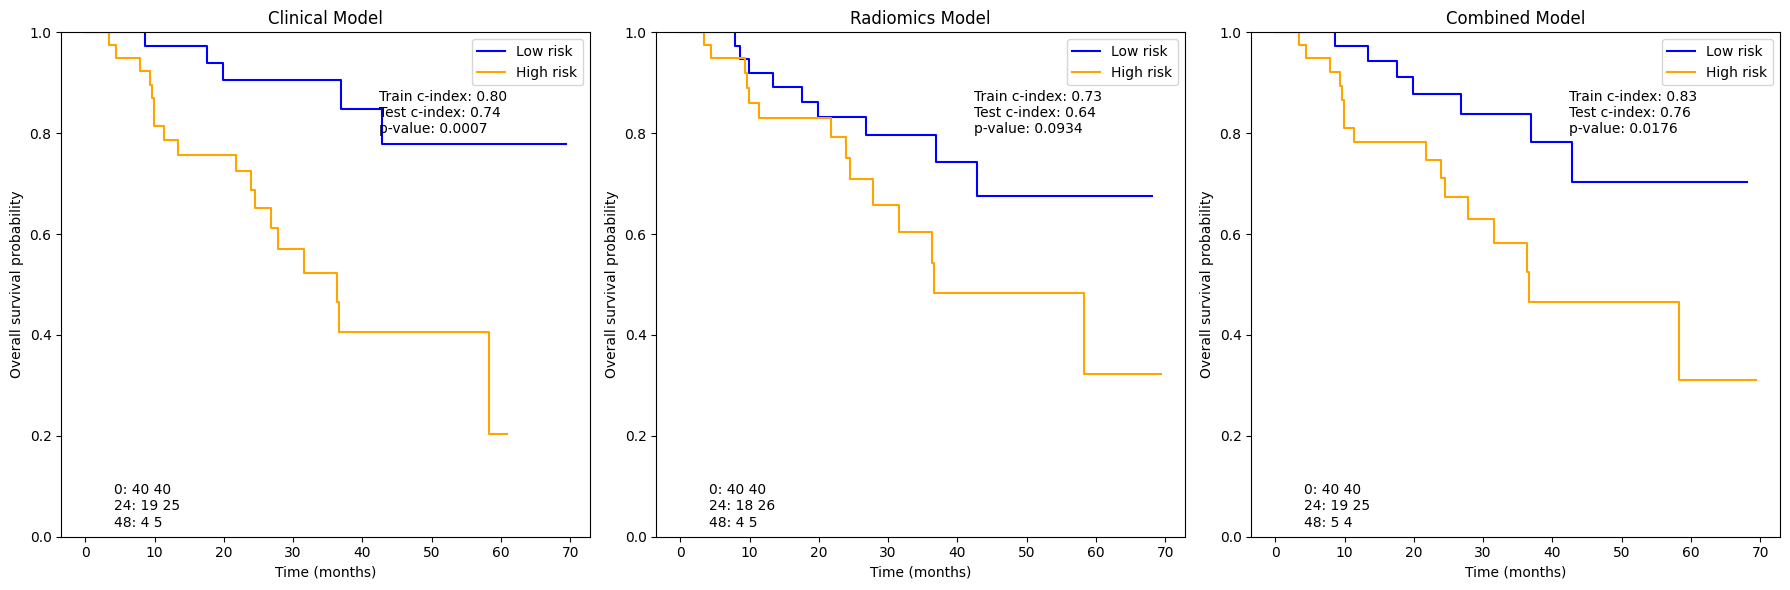

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from lifelines.utils import concordance_index

# Load data
df = pd.read_csv('/Intern Programming/data/OPCdigits_t1t2_split.csv')
radiodata = pd.read_csv('/Intern Programming/data/output/umcg_radiomicsfeature_t1_GTVPT.csv', index_col='Unnamed: 0')

# Merge the two dataframes based on the patient ID column
merged_data = pd.merge(df, radiodata, on='PatientID')

# Split data into training and test sets
df_train = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'train']
df_test = merged_data.loc[merged_data['CVgroup_event_t1t2'] == 'test']

# Define variables
time_vars = ['TIME_LR', 'TIME_RR', 'TIME_LRR', 'TIME_MET', 'TIME_TumorSpecificSurvival', 'TIME_OS', 'TIME_DFS', 'TIME_RFS']
event_vars = ['LR_code', 'RR_code', 'LRR_code', 'MET_code', 'TumorSpecificSurvival_code', 'OS_code', 'DFS_code', 'RFS_code']

# Define significant predictors
sig_predictors = ['AGE', 'GESLACHT_codes', 'PACK_YEARS', 'TSTAD_codes_123VS4', 'NSTAD_codes_N01VSN2VSN3', 'P16_codes_newexperi', 'WHO_SCORE_codes_0VS123']
radio_predictors = ['original_glszm_ZoneEntropy', 'original_firstorder_Minimum']  # Replace with actual radiomics predictors for each outcome

# Define outcome index (e.g., 0 for TIME_LR and LR_code)
outcome_idx = 5

# Combine predictors for the combined model
combined_predictors = sig_predictors + radio_predictors

# Initialize Cox Proportional Hazards model for clinical, radiomics, and combined models
cph_clinical = CoxPHFitter()
cph_radiomics = CoxPHFitter()
cph_combined = CoxPHFitter()

# Fit the models on training data
cph_clinical.fit(df_train[sig_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_radiomics.fit(df_train[radio_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])
cph_combined.fit(df_train[combined_predictors + [time_vars[outcome_idx], event_vars[outcome_idx]]], duration_col=time_vars[outcome_idx], event_col=event_vars[outcome_idx])

# Predict partial hazards for training data
train_pred_clinical = cph_clinical.predict_partial_hazard(df_train[sig_predictors])
train_pred_radiomics = cph_radiomics.predict_partial_hazard(df_train[radio_predictors])
train_pred_combined = cph_combined.predict_partial_hazard(df_train[combined_predictors])

# Calculate concordance index for training data
train_cindex_clinical = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_clinical, df_train[event_vars[outcome_idx]])
train_cindex_radiomics = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_radiomics, df_train[event_vars[outcome_idx]])
train_cindex_combined = concordance_index(df_train[time_vars[outcome_idx]], -train_pred_combined, df_train[event_vars[outcome_idx]])

# Predict partial hazards for test data
test_pred_clinical = cph_clinical.predict_partial_hazard(df_test[sig_predictors])
test_pred_radiomics = cph_radiomics.predict_partial_hazard(df_test[radio_predictors])
test_pred_combined = cph_combined.predict_partial_hazard(df_test[combined_predictors])

# Calculate concordance index for test data
test_cindex_clinical = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_clinical, df_test[event_vars[outcome_idx]])
test_cindex_radiomics = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_radiomics, df_test[event_vars[outcome_idx]])
test_cindex_combined = concordance_index(df_test[time_vars[outcome_idx]], -test_pred_combined, df_test[event_vars[outcome_idx]])

# Plot Kaplan-Meier survival curves
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to plot KM curves
def plot_km_curves(kmf, df, preds, time_var, event_var, title, ax, cindex_train, cindex_test):
    median_pred = preds.median()
    high_risk = preds > median_pred
    low_risk = preds <= median_pred
    
    kmf.fit(df[time_var][low_risk], event_observed=df[event_var][low_risk], label='Low risk')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='blue', linestyle='-')
    kmf.fit(df[time_var][high_risk], event_observed=df[event_var][high_risk], label='High risk')
    kmf.plot_survival_function(ax=ax, ci_show=False, color='orange', linestyle='-')
    
    # Calculate p-value using log-rank test
    results = logrank_test(df[time_var][low_risk], df[time_var][high_risk], 
                           event_observed_A=df[event_var][low_risk], 
                           event_observed_B=df[event_var][high_risk])
    p_value = results.p_value
    
    ax.set_title(title)
    ax.set_xlabel('Time (months)')
    ax.set_ylabel('Overall survival probability')
    ax.legend()
    ax.set_ylim(0, 1)  # Set y-axis limits to 0-1 for survival probability
    ax.text(0.6, 0.8, f'Train c-index: {cindex_train:.2f}\nTest c-index: {cindex_test:.2f}\np-value: {p_value:.4f}', transform=ax.transAxes)
    
    # Add number at risk
    time_points = np.arange(0, df[time_var].max(), step=24)
    at_risk_counts = [(df[time_var][high_risk] >= t).sum() for t in time_points]
    at_risk_counts_low = [(df[time_var][low_risk] >= t).sum() for t in time_points]
    at_risk_text = "\n".join([f"{t:.0f}: {ar} {al}" for t, ar, al in zip(time_points, at_risk_counts, at_risk_counts_low)])
    ax.text(0.1, 0.02, at_risk_text, transform=ax.transAxes)

# Initialize Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Plot clinical model KM curves
plot_km_curves(kmf, df_test, test_pred_clinical, time_vars[outcome_idx], event_vars[outcome_idx], 'Clinical Model', axes[0], train_cindex_clinical, test_cindex_clinical)

# Plot radiomics model KM curves
plot_km_curves(kmf, df_test, test_pred_radiomics, time_vars[outcome_idx], event_vars[outcome_idx], 'Radiomics Model', axes[1], train_cindex_radiomics, test_cindex_radiomics)

# Plot combined model KM curves
plot_km_curves(kmf, df_test, test_pred_combined, time_vars[outcome_idx], event_vars[outcome_idx], 'Combined Model', axes[2], train_cindex_combined, test_cindex_combined)

plt.tight_layout()
plt.show()


In the lifelines library, the plot_survival_function method of KaplanMeierFitter has several options for customizing the plot's appearance, including changing the line style, line width, and other visual aspects. Here are some options you can use:

Line Style (linestyle):

You can use different line styles such as '-' (solid), '--' (dashed), '-.' (dash-dot), ':' (dotted), etc.
Line Width (linewidth):

You can adjust the width of the lines with the linewidth parameter.
Confidence Interval (ci_show):

You can show or hide the confidence interval with ci_show=True or ci_show=False.
Confidence Interval Alpha (ci_alpha):

You can set the transparency of the confidence interval with ci_alpha.
Step Function (step_function):

You can set the step function style with step_function=True

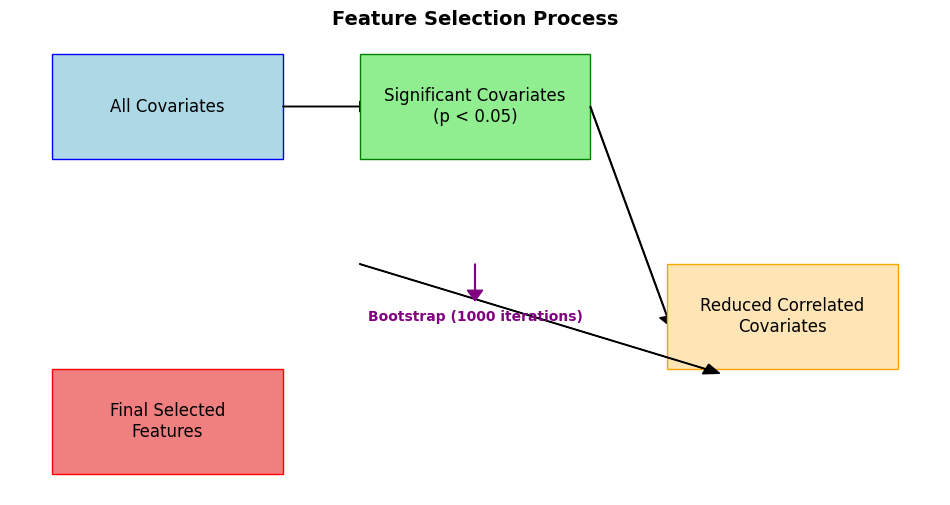

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 6))

# Step 1: Univariate Analysis
ax.add_patch(patches.Rectangle((0.1, 0.7), 0.3, 0.2, edgecolor='blue', facecolor='lightblue'))
plt.text(0.25, 0.8, 'All Covariates', horizontalalignment='center', verticalalignment='center', fontsize=12)
plt.arrow(0.4, 0.8, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')

ax.add_patch(patches.Rectangle((0.5, 0.7), 0.3, 0.2, edgecolor='green', facecolor='lightgreen'))
plt.text(0.65, 0.8, 'Significant Covariates\n(p < 0.05)', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Step 2: Correlation and BIC-Based Selection
plt.arrow(0.8, 0.8, 0.1, -0.4, head_width=0.02, head_length=0.02, fc='black', ec='black')

ax.add_patch(patches.Rectangle((0.9, 0.3), 0.3, 0.2, edgecolor='orange', facecolor='moccasin'))
plt.text(1.05, 0.4, 'Reduced Correlated\nCovariates', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Step 3: Stepwise Bootstrap Selection
plt.arrow(0.5, 0.5, 0.45, -0.2, head_width=0.02, head_length=0.02, fc='black', ec='black')

ax.add_patch(patches.Rectangle((0.1, 0.1), 0.3, 0.2, edgecolor='red', facecolor='lightcoral'))
plt.text(0.25, 0.2, 'Final Selected\nFeatures', horizontalalignment='center', verticalalignment='center', fontsize=12)

# Annotation for bootstrap
plt.text(0.65, 0.4, 'Bootstrap (1000 iterations)', horizontalalignment='center', verticalalignment='center', fontsize=10, color='purple', fontweight='bold')
plt.arrow(0.65, 0.5, 0, -0.05, head_width=0.02, head_length=0.02, fc='purple', ec='purple')

# Removing axes for a cleaner look
ax.axis('off')

plt.title('Feature Selection Process', fontsize=14, fontweight='bold')
plt.show()
